In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

%load_ext autoreload
%autoreload 2
import h5py

from pathlib import Path
from sglm.models import sglm_cv
import itertools
import time
import glob
import numpy as np
import pandas as pd
import numpy as np
from sglm.features import gen_signal_df as gsd
from sglm.features import build_features as bf
from sglm.features import setup_model_fit as smf
from sglm.models import sglm_cv
from sglm import models
from sglm.visualization import visualize
from sglm.models import train_model
from sglm.models import eval
from sglm import features
import sys
import os
from pathlib import Path
import matplotlib.pyplot as plt
import json

import traceback
import warnings
import sys

In [2]:
# From stack overflow
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

In [3]:
def extract_multifiles(wt_used, signal_files, widest_orders, shift_spacer='_sft_', ignore_missing=True):
    # needed info
    # Params: wt_used, signal_files, widest_orders, multifile_fit
    # Returns: mouse_names, combo_dfs, combo_fns, X_cols_sftd
    
    
    if ignore_missing:
        dropped_files = [_ for _ in signal_files if not Path(_).exists()]
        signal_files = [_ for _ in signal_files if _ not in dropped_files]
        display(f'Dropped files:', dropped_files)
        display(f'Signal files:', signal_files)
    
    file_ids = [Path(_).parts[-1] for _ in signal_files]
    print('file_ids', file_ids)
    combo_dfs, X_cols_sftd, _ = smf.multi_file_analysis_prep(signal_files, widest_orders, file_ids, shift_spacer='_sft_', keep_unshifted=True)
#     combo_dfs, X_cols_sftd, _ = smf.multi_file_analysis_prep_nosft(signal_files, widest_orders, file_ids)
    combo_fns = ['_'.join(wt_used).replace('WT', '').replace('S', '')]
    mouse_names = combo_fns

    return mouse_names, combo_dfs, combo_fns, X_cols_sftd

In [4]:
def dump_dict_to_json(source_dict, json_path):
    with open(str((json_path).resolve()), 'w') as json_file:
        json.dump(source_dict, json_file)

def read_json(json_path):
    with open(str((json_path).resolve()), 'r') as json_file:
        read_json = json.load(json_file)
    return read_json

In [5]:
def id_rows_with_all_cols(dfrel_basis,
                          X_y_pairings,
                          X_cols_sftd, 
                          drop_cols_basis = ['nTrial', 'nTrial_filenum',
                                             'cpn', 'cpx', 'spnnr', 'spxnr', 'spnr', 'spxr',
                                             
                                             'photometryCenterInIndex', 'photometryCenterOutIndex',
                                             'photometrySideInIndexr', 'photometrySideInIndexnr',
                                             'photometrySideOutIndex', 'spnnrOff',
                                             
                                             'photometrySideInIndexAA', 'photometrySideInIndexAa',
                                             'photometrySideInIndexaA', 'photometrySideInIndexaa',
                                             'photometrySideInIndexAB', 'photometrySideInIndexAb',
                                             'photometrySideInIndexaB', 'photometrySideInIndexab',
#                                              'sl',
#                                              'slOff'
                                            ]):
    full_drop_basis = []
    y_col_lst = []
    for X_y_dct in X_y_pairings:
        full_drop_basis += bf.col_shift_bounds_dict_to_col_list(X_y_dct['X_cols'], X_cols_sftd)
        y_col_lst += [X_y_dct['y_col']]
    y_col_drop_basis = sorted(list(set(y_col_lst)))
    full_drop_basis = sorted(list(set(drop_cols_basis + full_drop_basis + y_col_drop_basis)))

    num_cols_na = (dfrel_basis[full_drop_basis].isna().sum(axis=1))
    num_y_0 = (dfrel_basis[y_col_drop_basis] == 0).sum(axis=1)
    has_all_cols = (num_cols_na == 0)&(num_y_0 == 0)

    return has_all_cols

def warn_with_traceback(message, category, filename, lineno, file=None, line=None):

    log = file if hasattr(file,'write') else sys.stderr
    traceback.print_stack(file=log)
    log.write(warnings.formatwarning(message, category, filename, lineno, line))

warnings.showwarning = warn_with_traceback

In [6]:
def get_holdout_and_cv_idx(df_available, pholdout, folds, pgss, filter_series, id_cols=['nTrial_filenum']):
    holdout_series = models.split_data.holdout_split_by_trial_id(df_available,
                                                                id_cols=id_cols,
                                                                perc_holdout=pholdout)
    cv_idx_lst = models.split_data.cv_idx_by_trial_id(dfrel_basis_has_all_cols[(~holdout_series)&(filter_series)],
                                                             trial_id_columns=id_cols,
                                                             num_folds=folds,
                                                             test_size=pgss)
    return holdout_series, cv_idx_lst

In [7]:
### Part 1
param_set_json_name = 'full_model_param_set.json'

# source_data_path = Path(r'/Users/Josh/Documents/github_repos/sabatinilab-glm/sglm/data/Mike/interim')
# output_path = Path(r'/Users/Josh/Documents/github_repos/sabatinilab-glm/sglm/outputs_clean')

# source_data_path = Path(r'/Users/josh/Documents/github_repos_repos/sabatinilab-glm/sglm/data/Mike/interim_check')
# output_path = Path(r'/Users/josh/Documents/github_repos_repos/sabatinilab-glm/sglm/outputs_check')

# source_data_path = Path(r'/Users/josh/Documents/github_repos_repos/sabatinilab-glm/sglm/data/Mike/mike-GLM_8020-interim')
# output_path = Path(r'/Users/josh/Documents/github_repos_repos/sabatinilab-glm/sglm/outputs-mike-GLM_8020')


# source_data_path = Path(r'/Users/josh/Documents/github_repos_repos/sabatinilab-glm/sglm/data/Mike/lynne-sanity-interim')
# output_path = Path(r'/Users/josh/Documents/github_repos_repos/sabatinilab-glm/sglm/outputs_lynne-sanity')

# source_data_path = Path(r'/Users/Josh/Documents/github_repos/sabatinilab-glm/sglm/data/Mike/mike-GLM_7030-interim-rerunMac')
# output_path = Path(r'/Users/Josh/Documents/github_repos/sabatinilab-glm/sglm/outputs_mike-GLM_7030')

# source_data_path = Path(r'/Users/Josh/Documents/github_repos/sabatinilab-glm/sglm/data/Mike/mike-GLM_8020-interim-rerunMac')
# output_path = Path(r'/Users/Josh/Documents/github_repos/sabatinilab-glm/sglm/outputs_mike-GLM_8020')

source_data_path = Path(r'/Users/Josh/Documents/github_repos/sabatinilab-glm/sglm/data/Mike/mike-GLM_9010-interim-rerunMac')
output_path = Path(r'/Users/Josh/Documents/github_repos/sabatinilab-glm/sglm/outputs_mike-GLM_9010')

preproc_params_name = r'preproc_params.json'
basis_name = r'_basis.csv'
# figname = 'fig_8020'
# groupid = 'g1'
figname = 'fig'
groupid = 'g'
# param_set_id = '-20_+20_rwd_wco_fixedfilelist'
param_set_id = '-20_+20_rerunMac-full'
neg_order = -20
pos_order = 20
fix_training = True
num_runs = 3
# num_runs = 10
# folds = 10
folds = 1
pholdout = 0.5
pgss = 0.2
score_method = 'mse'
val_test_inx_sel_method = 'irun'

X_y_pairings_lst = []
# X_y_pairings_lst += [[
#     {'X_cols': {
#                 'photometryCenterInIndex':(0,0),
#                 'photometryCenterOutIndex':(0,0),
#                 'photometrySideInIndex':(0,0),
#                 'photometrySideInIndexr':(0,0),                
#                 'photometrySideOutIndex':(0,0),
#                 'sl': (0,0),
#                 'spnnrOff': (0,0),
#                },
#      'y_col': 'gDA',
# #      'y_col': 'gGLUr',
# #      'y_col': 'GCAMP',
#      'name': 'base_simple'
#      },
#     {'X_cols': {
#                 'photometryCenterInIndex':(0,0),
#                 'photometryCenterOutIndex':(0,0),
#                 'photometrySideInIndexAA':(0,0),
#                 'photometrySideInIndexAa':(0,0),
#                 'photometrySideInIndexaA':(0,0),
#                 'photometrySideInIndexaa':(0,0),
#                 'photometrySideInIndexAB':(0,0),
#                 'photometrySideInIndexAb':(0,0),
#                 'photometrySideInIndexaB':(0,0),
#                 'photometrySideInIndexab':(0,0),
#                 'photometrySideOutIndex':(0,0),
#                 'sl': (0,0),
#                 'spnnrOff': (0,0),
#                },
#      'y_col': 'gDA',
# #      'y_col': 'gGLUr',
# #      'y_col': 'GCAMP',
#      'name': 'base_words'},

# ]]
X_y_pairings_lst += [[
    {'X_cols': {
                'photometryCenterInIndex':(0,0),
                'photometryCenterOutIndexLt':(0,0),
                'photometryCenterOutIndexRt':(0,0),
                'photometrySideInIndex':(0,0),
                'photometrySideInIndexr':(0,0),
                'photometrySideOutIndexLt':(0,0),
                'photometrySideOutIndexRt':(0,0),
               },
     'y_col': 'GCAMP',
     'name': 'base_simple'
     },

]]

# Select hyper parameters for GLM to use for model selection
# Step 1: Create a dictionary of lists for these relevant keywords...
kwargs_iterations = {
    # 'alpha': [0],
    # 'l1_ratio': [0],

#     'alpha': [0.0, 0.01, 0.1, 1.0],
#     'l1_ratio': [0.0, 0.01, 0.1, 1.0],
#     'alpha': [0.0, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0, 100000.0, 1000000.0],
    'alpha': [0.0],
    'l1_ratio': [0.0],
}

# Step 2: Create a dictionary for the fixed keyword arguments that do not require iteration...
kwargs_fixed = {
    'max_iter': 10000,
    'fit_intercept': False
}

dfrr_cols = ['signal_file', 'file_num', 'nTrial', 'nTrial_filenum', 'nEndTrial', 'wi_trial_keep',
#              'nTrial_hard', 'nEndTrial_hard', 'diffTrialNums_hard', 'wi_trial_keep_hard',
             'has_all_cols',
#              'gDA',
#              'gGLUr',
#              'gDA', 'gACH', 'rDA', 'gGLUr', 'gGLUl',
             'GCAMP',
             'diffTrialNums', 'dupe',
             'photometryCenterInIndex',
             'photometryCenterOutIndexLt', 'photometryCenterOutIndexRt',
             'photometrySideInIndexr', 'photometrySideInIndexnr',
             'photometrySideOutIndex',
             'photometrySideOutIndexLt', 'photometrySideOutIndexRt',
#              'spnnrOff',
#              'sl',

             'photometrySideInIndexAA', 'photometrySideInIndexAa',
             'photometrySideInIndexaA','photometrySideInIndexaa',
             'photometrySideInIndexAB', 'photometrySideInIndexAb',
             'photometrySideInIndexaB','photometrySideInIndexab',
]


count_event_names = {
    'photometrySideInIndex': 'total_events',

    'photometrySideInIndexr': 'r',
    'photometrySideInIndexnr': 'nr',

    'photometrySideInIndexLt': 'lt',
    'photometrySideInIndexRt': 'rt',

    'photometrySideInIndexAA': 'AA',
    'photometrySideInIndexAa': 'Aa',
    'photometrySideInIndexAB': 'AB',
    'photometrySideInIndexAb': 'Ab',

    'photometrySideInIndexaA': 'aA',
    'photometrySideInIndexaa': 'aa',
    'photometrySideInIndexaB': 'aB',
    'photometrySideInIndexab': 'ab',
}

In [8]:
# Step 3: Generate iterable list of keyword sets for possible combinations
glm_kwarg_lst = sglm_cv.generate_mult_params(kwargs_iterations, kwargs_fixed)

In [9]:
### Part 1
data_path = (source_data_path / figname / groupid)

param_set_output_path = output_path / Path(figname) / Path(groupid) / Path(param_set_id)
param_set_output_path.mkdir(parents=True, exist_ok=False)

interim_preproc_errors_path = data_path / 'interim_preproc_errors.csv'
interim_preproc_errors_df = pd.read_csv(str(interim_preproc_errors_path.resolve()))
error_file_list = interim_preproc_errors_df['out_file_errors'].to_list()

preproc_params = read_json(source_data_path / preproc_params_name)
dump_dict_to_json(preproc_params, param_set_output_path / preproc_params_name)

param_set_dct = {
    'source_data_path': str((source_data_path).resolve()),
    'output_path': str((output_path).resolve()),
    'basis_name': basis_name,
    'figname': figname,
    'groupid': groupid,
    'param_set_id': param_set_id,
    'neg_order': neg_order,
    'pos_order': pos_order,
    'fix_training': fix_training,
    'num_runs': num_runs,
    'folds': folds,
    'pholdout': pholdout,
    'pgss': pgss,
    'score_method': score_method,
    'val_test_inx_sel_method': val_test_inx_sel_method,
    'X_y_pairings_lst': X_y_pairings_lst,
    'kwargs_iterations': kwargs_iterations,
    'kwargs_fixed': kwargs_fixed,
    'dfrr_cols': dfrr_cols,
    'count_event_names': count_event_names,
}
dump_dict_to_json(param_set_dct, param_set_output_path / param_set_json_name)

basis = pd.read_csv(source_data_path / basis_name, index_col=0)
basis['mouseid'] = basis['mouseid'].astype(str)
relevant_basis = basis[(basis['figname'] == figname)&(basis['groupid'] == groupid)]
wt_used = relevant_basis['mouseid'].tolist()

In [10]:
# Load Signal Data
signal_files = []
mouse_names = []
for inx, basis_row in relevant_basis.iterrows():
    signal_file_out = basis_row['signal_file_out']
    
    if signal_file_out in error_file_list:
        print(f'Preprocessing error found for file: {signal_file_out}')
        continue
    
    signal_path = data_path / signal_file_out
    signal_files.append(str(signal_path.resolve()))
    mouse_names.append(basis_row['mouseid'])

Preprocessing error found for file: GLM_SIGNALS_INTERIM_sstflp26_01252021.txt


In [11]:
# # Part 2: Generate base files to use by all runs and create folders for each run

# max_cols_len_lst = [max([len(_['X_cols']) for _ in inner_list]) for inner_list in X_y_pairings_lst]
# multi_start = time.time()
# for iXyp, X_y_pairings in enumerate(X_y_pairings_lst):

#     widest_orders = smf.xy_pairs_to_widest_orders([{'X_cols': smf.X_cols_dict_to_default(_['X_cols'], neg_order, pos_order),
#                                                     'y_col': _['y_col']} for _ in X_y_pairings])
#     max_cols_len = max_cols_len_lst[iXyp]
# #     mouse_names, combo_dfs, combo_fns, X_cols_sftd = extract_multifiles(wt_used, signal_files, widest_orders)
    
#     file_ids = [Path(_).parts[-1] for _ in signal_files]
#     signal_df, signal_df_unsft = smf.multi_file_analysis_prep(signal_files, widest_orders, file_ids)
#     combo_fns = ['_'.join(wt_used).replace('WT', '').replace('S', '')]
#     mouse_names = combo_fns
    
#     break

# whr = np.where(signal_df.fillna(-1) != signal_df_unsft.fillna(-1))
# signal_df.iloc[whr[0][:10],whr[1][:10]]

# signal_df_unsft.iloc[whr[0][:10],whr[1][:10]]
# break

In [12]:
# plot_width = 2
# plot_rows_lst = [_//plot_width + (_%plot_width > 0)*1 for _ in max_cols_len_lst]

In [13]:
# Part 2: Generate base files to use by all runs and create folders for each run

max_cols_len_lst = [max([len(_['X_cols']) for _ in inner_list]) for inner_list in X_y_pairings_lst]
for iXyp, X_y_pairings in enumerate(X_y_pairings_lst):
    
    Xyp_path = param_set_output_path / Path(f'iXyp_{iXyp}')
    Xyp_path.mkdir(parents=True, exist_ok=False)
    dump_dict_to_json(X_y_pairings, Xyp_path / Path('X_y_pairings.json'))
    
    
    widest_orders = smf.xy_pairs_to_widest_orders([{'X_cols': smf.X_cols_dict_to_default(_['X_cols'], neg_order, pos_order),
                                                    'y_col': _['y_col']} for _ in X_y_pairings])
    max_cols_len = max_cols_len_lst[iXyp]
    mouse_names, combo_dfs, combo_fns, X_cols_sftd = extract_multifiles(wt_used, signal_files, widest_orders, shift_spacer='_sft_')
    
    start = time.time()
    results_dict = {}
    
    dfrel_basis = combo_dfs[0].reset_index(drop=False).copy()
    
#     fn = Path(combo_fns[file_num].split('.')[0]).parts[-1]
    
    mouse_id = mouse_names[0]
    dfresids_cols = np.copy(dfrr_cols).tolist()
#     run_id = f'{fn}_{iXyp}'         
    has_all_cols = id_rows_with_all_cols(dfrel_basis, X_y_pairings, X_cols_sftd)
    if has_all_cols.sum() == 0:
        print(f'No datapoints found for non-NaN dropcols & non-zero ycols for fixed_training: {prefix}_{fn}')
        continue

    dfrel_basis['has_all_cols'] = has_all_cols    
    basis_column_indices = {
        'basis_cols': list(dfrel_basis.columns),
        'basis_index': list(dfrel_basis.index),
    }
    dump_dict_to_json(basis_column_indices, Xyp_path / Path('basis_column_indices.json'))
    
    
#     dfrel_basis[dfresids_cols].set_index(['nTrial_filenum'], append=True).to_hdf(str((Xyp_path / Path(f'combo_df.h5')).resolve()), key='combo', index=True,)
#     dfrel_basis[dfresids_cols].set_index(['nTrial_filenum'], append=True).to_csv(str((Xyp_path / Path(f'combo_df.csv')).resolve()), index=True)
    dfrel_basis[[_ for _ in dfrel_basis.columns if '_sft_' not in _]].to_csv(str((Xyp_path / Path(f'combo_df.csv')).resolve()), index=True)
#     dfrel_basis.to_hdf(str((Xyp_path / Path(f'combo_df.hd5')).resolve()), key='holdout', index=True)
    
#     dfrel_basis_reload = pd.read_csv(str((Xyp_path / Path(f'combo_df.csv')).resolve()), index_col=0)
#     dfrel_basis_reload, X_cols_sftd_reload = smf.timeshift_vals_by_dict(dfrel_basis_reload, widest_orders, keep_nans=True,
#                                                                         groupby_cols=['file_num'], shift_spacer='_sft_')
    
    dfrel_basis_has_all_cols = dfrel_basis[dfrel_basis['has_all_cols']]
    cv_holdout_idx_params = dict(df_available=dfrel_basis_has_all_cols,
                                 pholdout=pholdout,
                                 folds=folds,
                                 pgss=pgss,
                                 filter_series=dfrel_basis_has_all_cols['wi_trial_keep'],
                                 id_cols=['nTrial_filenum'])
    
    for irun in range(num_runs):
        holdout_irun, cv_idx_irun = get_holdout_and_cv_idx(**cv_holdout_idx_params)
        
        for iXyd, X_y_dct in enumerate(X_y_pairings):
            holdout_iXyd, cv_idx_iXyd = get_holdout_and_cv_idx(**cv_holdout_idx_params)
            
            for igkwargs, glm_kwargs in enumerate(glm_kwarg_lst):
                holdout_igkwargs, cv_idx_igkwargs = get_holdout_and_cv_idx(**cv_holdout_idx_params)
                
                run_path = Xyp_path / Path(f'iXyd_{iXyd}-ikwargs_{igkwargs}') / Path(f'irun_{irun}')
                run_path.mkdir(parents=True, exist_ok=False)
                
                specific_model_params = {
                    'mouse_id': mouse_id,
                    'irun': irun,
                    'iXyd': iXyd,
                    'igkwargs': igkwargs,
                    'X_y_dct': X_y_dct,
                    'X_cols': bf.col_shift_bounds_dict_to_col_list(X_y_dct['X_cols'], X_cols_sftd, shift_spacer='_sft_'),
                    'y_col': X_y_dct['y_col'],
                    'name': X_y_dct['name'],
                    'glm_kwargs': glm_kwargs,
                }
                
                dump_dict_to_json(specific_model_params, run_path / Path('specific_model_params.json'))
                dump_dict_to_json(param_set_dct, run_path / param_set_json_name)
                
                holdout_options_df = pd.DataFrame({'holdout_irun': holdout_irun,
                                           'holdout_iXyd':holdout_iXyd,
                                           'holdout_igkwargs':holdout_igkwargs},
                                          index=dfrel_basis_has_all_cols.index)
                
#                 holdout_df.to_hdf(str((run_path / 'holdout_options.hd5').resolve()), key='holdout')
                
                cv_options_dct = {
                    'cv_idx_irun':cv_idx_irun,
                    'cv_idx_iXyd':cv_idx_iXyd,
                    'cv_idx_igkwargs':cv_idx_igkwargs,
                }
#                 np.save(str((run_path/'cv_options.npy').resolve()), np.array(cv_options_dct, dtype='object'))
                
                kfold_cv_idx = cv_options_dct[f'cv_idx_{val_test_inx_sel_method}']
                holdout_srs = holdout_options_df[f'holdout_{val_test_inx_sel_method}']
                
                np.save(str((run_path/'kfold_cv_idx.npy').resolve()), np.array(kfold_cv_idx, dtype='object'))
                
#                 holdout_srs.to_hdf(str((run_path / 'holdout.hd5').resolve()), key='holdout')
                holdout_srs.to_csv(str((run_path / 'holdout.csv').resolve()), index=True)
                
                
                
                ####################################################################################
                ####################################################################################
                ####################################################################################
                ####################################################################################
                ####################################################################################
                #### JZ TODO: MOVE TO SEPARATE FILE FOR PARALLELIZATION OVER DEEPEST FOLDERS... ####
                #### JZ TODO: MOVE TO SEPARATE FILE FOR PARALLELIZATION OVER DEEPEST FOLDERS... ####
                #### JZ TODO: MOVE TO SEPARATE FILE FOR PARALLELIZATION OVER DEEPEST FOLDERS... ####
                #### JZ TODO: MOVE TO SEPARATE FILE FOR PARALLELIZATION OVER DEEPEST FOLDERS... ####
                #### JZ TODO: MOVE TO SEPARATE FILE FOR PARALLELIZATION OVER DEEPEST FOLDERS... ####
                ####################################################################################
                ####################################################################################
                ####################################################################################
                ####################################################################################
                ####################################################################################
                

'Dropped files:'

[]

'Signal files:'

['/Users/Josh/Documents/github_repos/sabatinilab-glm/sglm/data/Mike/mike-GLM_9010-interim/fig/g/GLM_SIGNALS_INTERIM_sstflp15_05302019.txt',
 '/Users/Josh/Documents/github_repos/sabatinilab-glm/sglm/data/Mike/mike-GLM_9010-interim/fig/g/GLM_SIGNALS_INTERIM_sstflp15_06072019.txt',
 '/Users/Josh/Documents/github_repos/sabatinilab-glm/sglm/data/Mike/mike-GLM_9010-interim/fig/g/GLM_SIGNALS_INTERIM_sstflp15_06112019.txt',
 '/Users/Josh/Documents/github_repos/sabatinilab-glm/sglm/data/Mike/mike-GLM_9010-interim/fig/g/GLM_SIGNALS_INTERIM_sstflp15_06132019.txt',
 '/Users/Josh/Documents/github_repos/sabatinilab-glm/sglm/data/Mike/mike-GLM_9010-interim/fig/g/GLM_SIGNALS_INTERIM_sstflp15_06172019.txt',
 '/Users/Josh/Documents/github_repos/sabatinilab-glm/sglm/data/Mike/mike-GLM_9010-interim/fig/g/GLM_SIGNALS_INTERIM_sstflp15_06202019.txt',
 '/Users/Josh/Documents/github_repos/sabatinilab-glm/sglm/data/Mike/mike-GLM_9010-interim/fig/g/GLM_SIGNALS_INTERIM_sstflp15_06242019.txt',
 '/Users/Josh/Docume

file_ids ['GLM_SIGNALS_INTERIM_sstflp15_05302019.txt', 'GLM_SIGNALS_INTERIM_sstflp15_06072019.txt', 'GLM_SIGNALS_INTERIM_sstflp15_06112019.txt', 'GLM_SIGNALS_INTERIM_sstflp15_06132019.txt', 'GLM_SIGNALS_INTERIM_sstflp15_06172019.txt', 'GLM_SIGNALS_INTERIM_sstflp15_06202019.txt', 'GLM_SIGNALS_INTERIM_sstflp15_06242019.txt', 'GLM_SIGNALS_INTERIM_sstflp16_07162019.txt', 'GLM_SIGNALS_INTERIM_sstflp16_07192019.txt', 'GLM_SIGNALS_INTERIM_sstflp16_07232019.txt', 'GLM_SIGNALS_INTERIM_sstflp16_07292019.txt', 'GLM_SIGNALS_INTERIM_sstflp16_08012019.txt', 'GLM_SIGNALS_INTERIM_sstflp16_08062019.txt', 'GLM_SIGNALS_INTERIM_sstflp16_08092019.txt', 'GLM_SIGNALS_INTERIM_sstflp16_08142019.txt', 'GLM_SIGNALS_INTERIM_sstflp17_09052019.txt', 'GLM_SIGNALS_INTERIM_sstflp17_09112019.txt', 'GLM_SIGNALS_INTERIM_sstflp17_09232019.txt', 'GLM_SIGNALS_INTERIM_sstflp17_09302019.txt', 'GLM_SIGNALS_INTERIM_sstflp17_10042019.txt', 'GLM_SIGNALS_INTERIM_sstflp17_10102019.txt', 'GLM_SIGNALS_INTERIM_sstflp17_10172019.txt', 

In [14]:
# [_ for _ in glob.glob('/Users/josh/Documents/github_repos/sabatinilab-glm/sglm/data/mike-GLM_8020-interim/fig_8020/g1/*') if '03232021' in _]

In [15]:

max_cols_len_lst = [max([len(_['X_cols']) for _ in inner_list]) for inner_list in X_y_pairings_lst]
for iXyp, _ in enumerate(X_y_pairings_lst):
    for irun in range(num_runs):
        for iXyd, X_y_dct in enumerate(X_y_pairings):
            for igkwargs, glm_kwargs in enumerate(glm_kwarg_lst):                
                run_start = time.time()
                
                Xyp_path = param_set_output_path / Path(f'iXyp_{iXyp}')
                X_y_pairings = read_json(Xyp_path / Path('X_y_pairings.json'))
                widest_orders = smf.xy_pairs_to_widest_orders([{'X_cols': smf.X_cols_dict_to_default(_['X_cols'], neg_order, pos_order),
                                                                'y_col': _['y_col']} for _ in X_y_pairings])
                max_cols_len = max_cols_len_lst[iXyp]
                
                run_path = Xyp_path / Path(f'iXyd_{iXyd}-ikwargs_{igkwargs}') / Path(f'irun_{irun}')
                specific_model_params = read_json(run_path / Path('specific_model_params.json'))
                param_set_dct = read_json(run_path / param_set_json_name)
                
                X_cols = specific_model_params['X_cols']
                y_col = specific_model_params['y_col']
                name = specific_model_params['name']
                
                kfold_cv_idx = np.load(str((run_path / 'kfold_cv_idx.npy').resolve()), allow_pickle=True)
                holdout_srs = pd.read_csv(str((run_path / 'holdout.csv').resolve()), index_col=0).iloc[:,0]
                
                basis_column_indices = read_json(Xyp_path / Path('basis_column_indices.json'))
#                 print(f'basis_column_indices: index: {len(basis_column_indices["basis_index"])}, columns: {len(basis_column_indices["basis_cols"])}')
                dfrel_basis_load = pd.read_csv(str((Xyp_path / Path(f'combo_df.csv')).resolve()))
#                 print('A: dfrel_basis_load.shape',dfrel_basis_load.shape)



                dfrel_basis_load, X_cols_sftd_load = smf.timeshift_vals_by_dict(dfrel_basis_load, widest_orders, keep_nans=True, groupby_cols=['file_num'], shift_spacer='_sft_',)
#                 print('B: dfrel_basis_load.shape',dfrel_basis_load.shape)
                
                X_cols_sftd_load = [_ for _ in basis_column_indices if _ in X_cols_sftd_load]
                dfrel_basis = dfrel_basis_load.loc[basis_column_indices['basis_index'], basis_column_indices['basis_cols']]
                dfrel_basis = dfrel_basis.copy()
                
#                 print('X_cols', X_cols)
#                 print('X_cols_sftd_load', X_cols_sftd_load)
                
                dfrel_basis['holdout'] = holdout_srs
                dfrel_basis_has_all_cols = dfrel_basis[dfrel_basis['has_all_cols']]
                
                df_train = dfrel_basis_has_all_cols[(~holdout_srs)&(dfrel_basis_has_all_cols['wi_trial_keep'])]
                df_holdout = dfrel_basis_has_all_cols[(holdout_srs)&(dfrel_basis_has_all_cols['wi_trial_keep'])]
                X_train, y_train, X_holdout, y_holdout = df_train[X_cols], df_train[y_col], df_holdout[X_cols], df_holdout[y_col]
                
#                 print('Pre-CV:', df_train.shape, '|', X_train.shape, y_train.shape, X_holdout.shape, y_holdout.shape)
                best_score, best_score_std, best_params, best_model, cv_results = models.sglm_cv.simple_cv_fit(X_train, y_train, kfold_cv_idx, [glm_kwargs], model_type='Normal',
                                                                                                            verbose=0, score_method=score_method)
#                 print('Pre-Fit:', df_train.shape, '|', X_train.shape, y_train.shape, X_holdout.shape, y_holdout.shape)
                glm, holdout_score, holdout_neg_mse_score = eval.training_fit_holdout_score(X_train, y_train, X_holdout, y_holdout, glm_kwargs)
                
                run_end = time.time()
                
                event_counts_train = {count_event_names[key]: df_train[key].sum() for key in count_event_names}
                event_counts_holdout = {count_event_names[key]: df_holdout[key].sum() for key in count_event_names}
                
                fitted_glm = {
                    'model': {
                        'intercept_': glm.intercept_,
                        'coef_': list(glm.coef_),
                        'X_names_': X_cols,
                        'y_name_': y_col,
                    },
                    'score': {
                        'mse_tr': -glm.neg_mse_score(X_train, y_train),
                        'mse_cv': cv_results['full_cv_results'][0]['cv_mse_score'],
                        'mse_te': -glm.neg_mse_score(X_holdout, y_holdout),
                        
                        'r2_tr': glm.r2_score(X_train, y_train),
                        'r2_cv': cv_results['full_cv_results'][0]['cv_R2_score'],
                        'r2_te': glm.r2_score(X_holdout, y_holdout),
                    },
                    'fit_details': {
                        'time_passed': str(run_end - run_start) + ' s',
                        'train_event_counts': event_counts_train,
                        'holdout_event_counts': event_counts_holdout,
                    },
                }
                dump_dict_to_json(fitted_glm, run_path / 'fitted_glm.json')
                
                assert len(cv_results['full_cv_results']) == 1
                assert holdout_neg_mse_score == glm.neg_mse_score(X_holdout, y_holdout)
                
                dfrel_basis['pred_'+y_col] = pd.Series(glm.predict(dfrel_basis_has_all_cols[X_cols]), index=dfrel_basis_has_all_cols.index)
                nonnan_X = (dfrel_basis[X_cols].isna().sum(axis=1) == 0)
                dfrel_basis['predALL_'+y_col] = pd.Series(glm.predict(dfrel_basis[X_cols][nonnan_X]), index=dfrel_basis.index[nonnan_X])
                dfrel_basis[dfresids_cols + ['holdout', y_col, 'pred_'+y_col, 'predALL_'+y_col]].to_csv(str((run_path / 'preds.csv').resolve()))
                
                print('======')

{'max_iter': 10000, 'fit_intercept': False, 'alpha': 0.0, 'l1_ratio': 0.0}
Running multi
Running multi
Running multi
Running multi
Multirun queue completedMultirun queue completed

Multirun queue completed
{'max_iter': 10000, 'fit_intercept': False, 'alpha': 0.0, 'l1_ratio': 0.0}
> cv_mean_score_train: -0.7696867084446616
> cv_R2_score: 0.2400859600475126
> cv_mean_score: -0.7539751224766449
Running multi
Multirun queue completed
{'max_iter': 10000, 'fit_intercept': False, 'alpha': 0.0, 'l1_ratio': 0.0}
Running multi
Running multi
Running multi
Running multi
Multirun queue completedMultirun queue completed
Multirun queue completed

{'max_iter': 10000, 'fit_intercept': False, 'alpha': 0.0, 'l1_ratio': 0.0}
> cv_mean_score_train: -0.7632615768492637
> cv_R2_score: 0.23374128315029596
> cv_mean_score: -0.7846120667946559
Running multi
Multirun queue completed
{'max_iter': 10000, 'fit_intercept': False, 'alpha': 0.0, 'l1_ratio': 0.0}
Running multi
Running multi
Running multi
Running multi


IndexError: index 2 is out of bounds for axis 0 with size 2

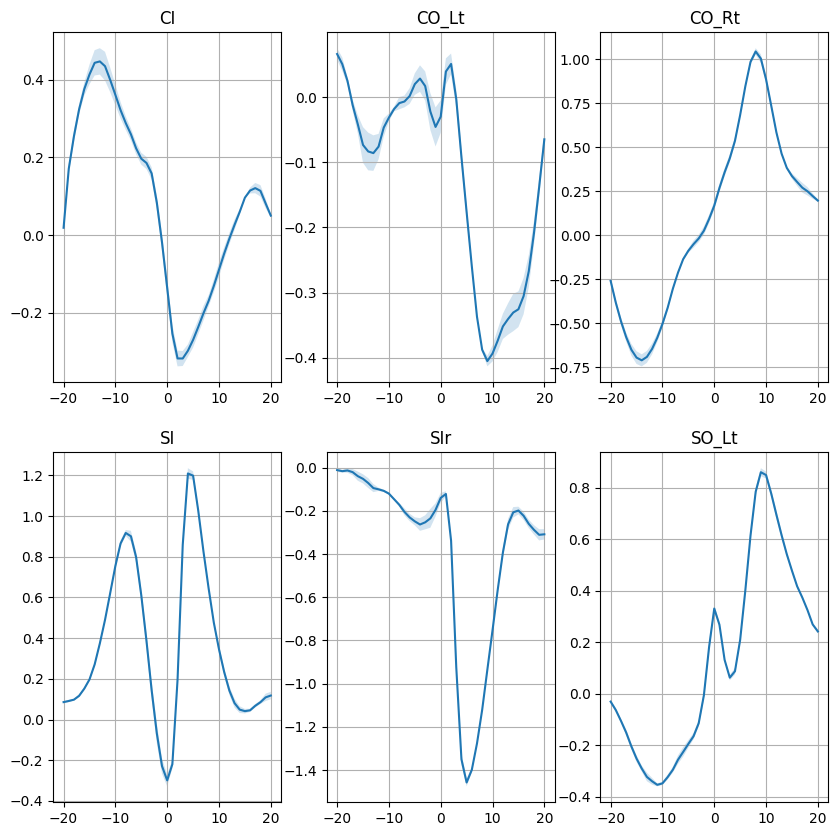

In [16]:

max_cols_len_lst = [max([len(_['X_cols']) for _ in inner_list]) for inner_list in X_y_pairings_lst]
for iXyp, _ in enumerate(X_y_pairings_lst):
    for iXyd, X_y_dct in enumerate(X_y_pairings):
        for igkwargs, glm_kwargs in enumerate(glm_kwarg_lst):
            agg_coefs_lst = []
            for irun in range(num_runs):
                run_start = time.time()
                
                Xyp_path = param_set_output_path / Path(f'iXyp_{iXyp}')
                run_path = Xyp_path / Path(f'iXyd_{iXyd}-ikwargs_{igkwargs}') / Path(f'irun_{irun}')
                fitted_glm = read_json(run_path / 'fitted_glm.json')
                
                coefs = pd.DataFrame(list(zip(fitted_glm['model']['X_names_'], fitted_glm['model']['coef_'])), columns=['name', 'coef'])
                coefs['name_lst'] = coefs['name'].str.split('_sft_')
                coefs['col'] = coefs['name_lst'].apply(lambda x: x[0])
                coefs['sft'] = coefs['name_lst'].apply(lambda x: x[1]).astype('int')
                
                agg_coefs_lst.append(coefs)
            
            agg_coefs = pd.concat(agg_coefs_lst)

            gb_coefs = agg_coefs.groupby(['col', 'sft'])['coef'].agg([np.mean, np.std, np.size])
            gb_coefs['lb'] = gb_coefs['mean'] - gb_coefs['std']/np.sqrt(gb_coefs['size'])*1.96
            gb_coefs['ub'] = gb_coefs['mean'] + gb_coefs['std']/np.sqrt(gb_coefs['size'])*1.96

            gb_coefs = gb_coefs.reset_index()
            fig,axes = plt.subplots(gb_coefs['col'].nunique()//3,3,figsize=(10,10))

            min_y = gb_coefs['lb'].min()-0.01
            max_y = gb_coefs['ub'].max()+0.01
            i = 0
            for gc, gc_df in gb_coefs.groupby('col'):
                axes[i//3,i%3].set_title(gc.replace('Index','').replace('photometry','').replace('enter','').replace('ut','_').replace('ide','').replace('In','I'))
                axes[i//3,i%3].plot(gc_df['sft'], gc_df['mean'])
                axes[i//3,i%3].fill_between(gc_df['sft'], gc_df['lb'], gc_df['ub'], alpha=0.2)
                axes[i//3,i%3].grid(True)
                i += 1

            i = 0
            for gc, gc_df in gb_coefs.groupby('col'):
                axes[i//3,i%3].set_ylim((min_y, max_y))
                i += 1

In [ ]:
break

In [ ]:

max_cols_len_lst = [max([len(_['X_cols']) for _ in inner_list]) for inner_list in X_y_pairings_lst]
for iXyp, _ in enumerate(X_y_pairings_lst):
    for iXyd, X_y_dct in enumerate(X_y_pairings):
        for igkwargs, glm_kwargs in enumerate(glm_kwarg_lst):
            irun = 0
            
            run_start = time.time()
            Xyp_path = param_set_output_path / Path(f'iXyp_{iXyp}')
            run_path = Xyp_path / Path(f'iXyd_{iXyd}-ikwargs_{igkwargs}') / Path(f'irun_{irun}')
            preds_df = pd.read_csv(run_path / 'preds.csv')
            preds_df = preds_df[preds_df['has_all_cols']]
            
            assert preds_df['holdout'].isna().sum() == 0
            preds_df['holdout'] = preds_df['holdout'].astype(bool)

            y_col = X_y_dct['y_col']
            preds_df['resids'] = preds_df[y_col] - preds_df['pred_'+y_col]
            preds_df['residsALL'] = preds_df[y_col] - preds_df['predALL_'+y_col]
            
            preds_df_train = preds_df[(~preds_df['holdout'])&preds_df[['wi_trial_keep']]]
            preds_df_holdout = preds_df[(preds_df['holdout'])&preds_df[['wi_trial_keep']]]
            

In [ ]:
preds_df.columns[28]

In [ ]:
agg_coefs

In [ ]:
# list(smf.timeshift_vals_by_dict(dfrel_basis, widest_orders, keep_nans=True, groupby_cols=['file_num'], shift_spacer='_sft_')[0].columns)
# list(dfrel_basis.columns)

In [ ]:
setup = list(df_train.columns)
basis = list(set(setup))
dupe = setup
for b in basis:
    cnt = dupe.count(b)
    if cnt > 1:
        print(b, cnt)


In [ ]:
specific_model_params

In [ ]:
a = ['photometryCenterInIndex_sft_-20', 'photometryCenterInIndex_sft_-19', 'photometryCenterInIndex_sft_-18', 'photometryCenterInIndex_sft_-17', 'photometryCenterInIndex_sft_-16', 'photometryCenterInIndex_sft_-15', 'photometryCenterInIndex_sft_-14', 'photometryCenterInIndex_sft_-13', 'photometryCenterInIndex_sft_-12', 'photometryCenterInIndex_sft_-11', 'photometryCenterInIndex_sft_-10', 'photometryCenterInIndex_sft_-9', 'photometryCenterInIndex_sft_-8', 'photometryCenterInIndex_sft_-7', 'photometryCenterInIndex_sft_-6', 'photometryCenterInIndex_sft_-5', 'photometryCenterInIndex_sft_-4', 'photometryCenterInIndex_sft_-3', 'photometryCenterInIndex_sft_-2', 'photometryCenterInIndex_sft_-1', 'photometryCenterInIndex_sft_0', 'photometryCenterInIndex_sft_1', 'photometryCenterInIndex_sft_2', 'photometryCenterInIndex_sft_3', 'photometryCenterInIndex_sft_4', 'photometryCenterInIndex_sft_5', 'photometryCenterInIndex_sft_6', 'photometryCenterInIndex_sft_7', 'photometryCenterInIndex_sft_8', 'photometryCenterInIndex_sft_9', 'photometryCenterInIndex_sft_10', 'photometryCenterInIndex_sft_11', 'photometryCenterInIndex_sft_12', 'photometryCenterInIndex_sft_13', 'photometryCenterInIndex_sft_14', 'photometryCenterInIndex_sft_15', 'photometryCenterInIndex_sft_16', 'photometryCenterInIndex_sft_17', 'photometryCenterInIndex_sft_18', 'photometryCenterInIndex_sft_19', 'photometryCenterInIndex_sft_20', 'photometrySideInIndex_sft_-20', 'photometrySideInIndex_sft_-19', 'photometrySideInIndex_sft_-18', 'photometrySideInIndex_sft_-17', 'photometrySideInIndex_sft_-16', 'photometrySideInIndex_sft_-15', 'photometrySideInIndex_sft_-14', 'photometrySideInIndex_sft_-13', 'photometrySideInIndex_sft_-12', 'photometrySideInIndex_sft_-11', 'photometrySideInIndex_sft_-10', 'photometrySideInIndex_sft_-9', 'photometrySideInIndex_sft_-8', 'photometrySideInIndex_sft_-7', 'photometrySideInIndex_sft_-6', 'photometrySideInIndex_sft_-5', 'photometrySideInIndex_sft_-4', 'photometrySideInIndex_sft_-3', 'photometrySideInIndex_sft_-2', 'photometrySideInIndex_sft_-1', 'photometrySideInIndex_sft_0', 'photometrySideInIndex_sft_1', 'photometrySideInIndex_sft_2', 'photometrySideInIndex_sft_3', 'photometrySideInIndex_sft_4', 'photometrySideInIndex_sft_5', 'photometrySideInIndex_sft_6', 'photometrySideInIndex_sft_7', 'photometrySideInIndex_sft_8', 'photometrySideInIndex_sft_9', 'photometrySideInIndex_sft_10', 'photometrySideInIndex_sft_11', 'photometrySideInIndex_sft_12', 'photometrySideInIndex_sft_13', 'photometrySideInIndex_sft_14', 'photometrySideInIndex_sft_15', 'photometrySideInIndex_sft_16', 'photometrySideInIndex_sft_17', 'photometrySideInIndex_sft_18', 'photometrySideInIndex_sft_19', 'photometrySideInIndex_sft_20', 'photometrySideInIndexr_sft_-20', 'photometrySideInIndexr_sft_-19', 'photometrySideInIndexr_sft_-18', 'photometrySideInIndexr_sft_-17', 'photometrySideInIndexr_sft_-16', 'photometrySideInIndexr_sft_-15', 'photometrySideInIndexr_sft_-14', 'photometrySideInIndexr_sft_-13', 'photometrySideInIndexr_sft_-12', 'photometrySideInIndexr_sft_-11', 'photometrySideInIndexr_sft_-10', 'photometrySideInIndexr_sft_-9', 'photometrySideInIndexr_sft_-8', 'photometrySideInIndexr_sft_-7', 'photometrySideInIndexr_sft_-6', 'photometrySideInIndexr_sft_-5', 'photometrySideInIndexr_sft_-4', 'photometrySideInIndexr_sft_-3', 'photometrySideInIndexr_sft_-2', 'photometrySideInIndexr_sft_-1', 'photometrySideInIndexr_sft_0', 'photometrySideInIndexr_sft_1', 'photometrySideInIndexr_sft_2', 'photometrySideInIndexr_sft_3', 'photometrySideInIndexr_sft_4', 'photometrySideInIndexr_sft_5', 'photometrySideInIndexr_sft_6', 'photometrySideInIndexr_sft_7', 'photometrySideInIndexr_sft_8', 'photometrySideInIndexr_sft_9', 'photometrySideInIndexr_sft_10', 'photometrySideInIndexr_sft_11', 'photometrySideInIndexr_sft_12', 'photometrySideInIndexr_sft_13', 'photometrySideInIndexr_sft_14', 'photometrySideInIndexr_sft_15', 'photometrySideInIndexr_sft_16', 'photometrySideInIndexr_sft_17', 'photometrySideInIndexr_sft_18', 'photometrySideInIndexr_sft_19', 'photometrySideInIndexr_sft_20', 'photometrySideOutIndex_sft_-20', 'photometrySideOutIndex_sft_-19', 'photometrySideOutIndex_sft_-18', 'photometrySideOutIndex_sft_-17', 'photometrySideOutIndex_sft_-16', 'photometrySideOutIndex_sft_-15', 'photometrySideOutIndex_sft_-14', 'photometrySideOutIndex_sft_-13', 'photometrySideOutIndex_sft_-12', 'photometrySideOutIndex_sft_-11', 'photometrySideOutIndex_sft_-10', 'photometrySideOutIndex_sft_-9', 'photometrySideOutIndex_sft_-8', 'photometrySideOutIndex_sft_-7', 'photometrySideOutIndex_sft_-6', 'photometrySideOutIndex_sft_-5', 'photometrySideOutIndex_sft_-4', 'photometrySideOutIndex_sft_-3', 'photometrySideOutIndex_sft_-2', 'photometrySideOutIndex_sft_-1', 'photometrySideOutIndex_sft_0', 'photometrySideOutIndex_sft_1', 'photometrySideOutIndex_sft_2', 'photometrySideOutIndex_sft_3', 'photometrySideOutIndex_sft_4', 'photometrySideOutIndex_sft_5', 'photometrySideOutIndex_sft_6', 'photometrySideOutIndex_sft_7', 'photometrySideOutIndex_sft_8', 'photometrySideOutIndex_sft_9', 'photometrySideOutIndex_sft_10', 'photometrySideOutIndex_sft_11', 'photometrySideOutIndex_sft_12', 'photometrySideOutIndex_sft_13', 'photometrySideOutIndex_sft_14', 'photometrySideOutIndex_sft_15', 'photometrySideOutIndex_sft_16', 'photometrySideOutIndex_sft_17', 'photometrySideOutIndex_sft_18', 'photometrySideOutIndex_sft_19', 'photometrySideOutIndex_sft_20', 'sl_sft_-20', 'sl_sft_-19', 'sl_sft_-18', 'sl_sft_-17', 'sl_sft_-16', 'sl_sft_-15', 'sl_sft_-14', 'sl_sft_-13', 'sl_sft_-12', 'sl_sft_-11', 'sl_sft_-10', 'sl_sft_-9', 'sl_sft_-8', 'sl_sft_-7', 'sl_sft_-6', 'sl_sft_-5', 'sl_sft_-4', 'sl_sft_-3', 'sl_sft_-2', 'sl_sft_-1', 'sl_sft_0', 'sl_sft_1', 'sl_sft_2', 'sl_sft_3', 'sl_sft_4', 'sl_sft_5', 'sl_sft_6', 'sl_sft_7', 'sl_sft_8', 'sl_sft_9', 'sl_sft_10', 'sl_sft_11', 'sl_sft_12', 'sl_sft_13', 'sl_sft_14', 'sl_sft_15', 'sl_sft_16', 'sl_sft_17', 'sl_sft_18', 'sl_sft_19', 'sl_sft_20', 'spnnrOff_sft_-20', 'spnnrOff_sft_-19', 'spnnrOff_sft_-18', 'spnnrOff_sft_-17', 'spnnrOff_sft_-16', 'spnnrOff_sft_-15', 'spnnrOff_sft_-14', 'spnnrOff_sft_-13', 'spnnrOff_sft_-12', 'spnnrOff_sft_-11', 'spnnrOff_sft_-10', 'spnnrOff_sft_-9', 'spnnrOff_sft_-8', 'spnnrOff_sft_-7', 'spnnrOff_sft_-6', 'spnnrOff_sft_-5', 'spnnrOff_sft_-4', 'spnnrOff_sft_-3', 'spnnrOff_sft_-2', 'spnnrOff_sft_-1', 'spnnrOff_sft_0', 'spnnrOff_sft_1', 'spnnrOff_sft_2', 'spnnrOff_sft_3', 'spnnrOff_sft_4', 'spnnrOff_sft_5', 'spnnrOff_sft_6', 'spnnrOff_sft_7', 'spnnrOff_sft_8', 'spnnrOff_sft_9', 'spnnrOff_sft_10', 'spnnrOff_sft_11', 'spnnrOff_sft_12', 'spnnrOff_sft_13', 'spnnrOff_sft_14', 'spnnrOff_sft_15', 'spnnrOff_sft_16', 'spnnrOff_sft_17', 'spnnrOff_sft_18', 'spnnrOff_sft_19', 'spnnrOff_sft_20']
b = ['photometryCenterInIndex_sft_-20', 'photometryCenterInIndex_sft_-19', 'photometryCenterInIndex_sft_-18', 'photometryCenterInIndex_sft_-17', 'photometryCenterInIndex_sft_-16', 'photometryCenterInIndex_sft_-15', 'photometryCenterInIndex_sft_-14', 'photometryCenterInIndex_sft_-13', 'photometryCenterInIndex_sft_-12', 'photometryCenterInIndex_sft_-11', 'photometryCenterInIndex_sft_-10', 'photometryCenterInIndex_sft_-9', 'photometryCenterInIndex_sft_-8', 'photometryCenterInIndex_sft_-7', 'photometryCenterInIndex_sft_-6', 'photometryCenterInIndex_sft_-5', 'photometryCenterInIndex_sft_-4', 'photometryCenterInIndex_sft_-3', 'photometryCenterInIndex_sft_-2', 'photometryCenterInIndex_sft_-1', 'photometryCenterInIndex_sft_0', 'photometryCenterInIndex_sft_1', 'photometryCenterInIndex_sft_2', 'photometryCenterInIndex_sft_3', 'photometryCenterInIndex_sft_4', 'photometryCenterInIndex_sft_5', 'photometryCenterInIndex_sft_6', 'photometryCenterInIndex_sft_7', 'photometryCenterInIndex_sft_8', 'photometryCenterInIndex_sft_9', 'photometryCenterInIndex_sft_10', 'photometryCenterInIndex_sft_11', 'photometryCenterInIndex_sft_12', 'photometryCenterInIndex_sft_13', 'photometryCenterInIndex_sft_14', 'photometryCenterInIndex_sft_15', 'photometryCenterInIndex_sft_16', 'photometryCenterInIndex_sft_17', 'photometryCenterInIndex_sft_18', 'photometryCenterInIndex_sft_19', 'photometryCenterInIndex_sft_20', 'photometrySideInIndex_sft_-20', 'photometrySideInIndex_sft_-19', 'photometrySideInIndex_sft_-18', 'photometrySideInIndex_sft_-17', 'photometrySideInIndex_sft_-16', 'photometrySideInIndex_sft_-15', 'photometrySideInIndex_sft_-14', 'photometrySideInIndex_sft_-13', 'photometrySideInIndex_sft_-12', 'photometrySideInIndex_sft_-11', 'photometrySideInIndex_sft_-10', 'photometrySideInIndex_sft_-9', 'photometrySideInIndex_sft_-8', 'photometrySideInIndex_sft_-7', 'photometrySideInIndex_sft_-6', 'photometrySideInIndex_sft_-5', 'photometrySideInIndex_sft_-4', 'photometrySideInIndex_sft_-3', 'photometrySideInIndex_sft_-2', 'photometrySideInIndex_sft_-1', 'photometrySideInIndex_sft_0', 'photometrySideInIndex_sft_1', 'photometrySideInIndex_sft_2', 'photometrySideInIndex_sft_3', 'photometrySideInIndex_sft_4', 'photometrySideInIndex_sft_5', 'photometrySideInIndex_sft_6', 'photometrySideInIndex_sft_7', 'photometrySideInIndex_sft_8', 'photometrySideInIndex_sft_9', 'photometrySideInIndex_sft_10', 'photometrySideInIndex_sft_11', 'photometrySideInIndex_sft_12', 'photometrySideInIndex_sft_13', 'photometrySideInIndex_sft_14', 'photometrySideInIndex_sft_15', 'photometrySideInIndex_sft_16', 'photometrySideInIndex_sft_17', 'photometrySideInIndex_sft_18', 'photometrySideInIndex_sft_19', 'photometrySideInIndex_sft_20', 'photometrySideInIndexr_sft_-20', 'photometrySideInIndexr_sft_-19', 'photometrySideInIndexr_sft_-18', 'photometrySideInIndexr_sft_-17', 'photometrySideInIndexr_sft_-16', 'photometrySideInIndexr_sft_-15', 'photometrySideInIndexr_sft_-14', 'photometrySideInIndexr_sft_-13', 'photometrySideInIndexr_sft_-12', 'photometrySideInIndexr_sft_-11', 'photometrySideInIndexr_sft_-10', 'photometrySideInIndexr_sft_-9', 'photometrySideInIndexr_sft_-8', 'photometrySideInIndexr_sft_-7', 'photometrySideInIndexr_sft_-6', 'photometrySideInIndexr_sft_-5', 'photometrySideInIndexr_sft_-4', 'photometrySideInIndexr_sft_-3', 'photometrySideInIndexr_sft_-2', 'photometrySideInIndexr_sft_-1', 'photometrySideInIndexr_sft_0', 'photometrySideInIndexr_sft_1', 'photometrySideInIndexr_sft_2', 'photometrySideInIndexr_sft_3', 'photometrySideInIndexr_sft_4', 'photometrySideInIndexr_sft_5', 'photometrySideInIndexr_sft_6', 'photometrySideInIndexr_sft_7', 'photometrySideInIndexr_sft_8', 'photometrySideInIndexr_sft_9', 'photometrySideInIndexr_sft_10', 'photometrySideInIndexr_sft_11', 'photometrySideInIndexr_sft_12', 'photometrySideInIndexr_sft_13', 'photometrySideInIndexr_sft_14', 'photometrySideInIndexr_sft_15', 'photometrySideInIndexr_sft_16', 'photometrySideInIndexr_sft_17', 'photometrySideInIndexr_sft_18', 'photometrySideInIndexr_sft_19', 'photometrySideInIndexr_sft_20', 'photometrySideOutIndex_sft_-20', 'photometrySideOutIndex_sft_-19', 'photometrySideOutIndex_sft_-18', 'photometrySideOutIndex_sft_-17', 'photometrySideOutIndex_sft_-16', 'photometrySideOutIndex_sft_-15', 'photometrySideOutIndex_sft_-14', 'photometrySideOutIndex_sft_-13', 'photometrySideOutIndex_sft_-12', 'photometrySideOutIndex_sft_-11', 'photometrySideOutIndex_sft_-10', 'photometrySideOutIndex_sft_-9', 'photometrySideOutIndex_sft_-8', 'photometrySideOutIndex_sft_-7', 'photometrySideOutIndex_sft_-6', 'photometrySideOutIndex_sft_-5', 'photometrySideOutIndex_sft_-4', 'photometrySideOutIndex_sft_-3', 'photometrySideOutIndex_sft_-2', 'photometrySideOutIndex_sft_-1', 'photometrySideOutIndex_sft_0', 'photometrySideOutIndex_sft_1', 'photometrySideOutIndex_sft_2', 'photometrySideOutIndex_sft_3', 'photometrySideOutIndex_sft_4', 'photometrySideOutIndex_sft_5', 'photometrySideOutIndex_sft_6', 'photometrySideOutIndex_sft_7', 'photometrySideOutIndex_sft_8', 'photometrySideOutIndex_sft_9', 'photometrySideOutIndex_sft_10', 'photometrySideOutIndex_sft_11', 'photometrySideOutIndex_sft_12', 'photometrySideOutIndex_sft_13', 'photometrySideOutIndex_sft_14', 'photometrySideOutIndex_sft_15', 'photometrySideOutIndex_sft_16', 'photometrySideOutIndex_sft_17', 'photometrySideOutIndex_sft_18', 'photometrySideOutIndex_sft_19', 'photometrySideOutIndex_sft_20', 'sl_sft_-20', 'sl_sft_-19', 'sl_sft_-18', 'sl_sft_-17', 'sl_sft_-16', 'sl_sft_-15', 'sl_sft_-14', 'sl_sft_-13', 'sl_sft_-12', 'sl_sft_-11', 'sl_sft_-10', 'sl_sft_-9', 'sl_sft_-8', 'sl_sft_-7', 'sl_sft_-6', 'sl_sft_-5', 'sl_sft_-4', 'sl_sft_-3', 'sl_sft_-2', 'sl_sft_-1', 'sl_sft_0', 'sl_sft_1', 'sl_sft_2', 'sl_sft_3', 'sl_sft_4', 'sl_sft_5', 'sl_sft_6', 'sl_sft_7', 'sl_sft_8', 'sl_sft_9', 'sl_sft_10', 'sl_sft_11', 'sl_sft_12', 'sl_sft_13', 'sl_sft_14', 'sl_sft_15', 'sl_sft_16', 'sl_sft_17', 'sl_sft_18', 'sl_sft_19', 'sl_sft_20', 'spnnrOff_sft_-20', 'spnnrOff_sft_-19', 'spnnrOff_sft_-18', 'spnnrOff_sft_-17', 'spnnrOff_sft_-16', 'spnnrOff_sft_-15', 'spnnrOff_sft_-14', 'spnnrOff_sft_-13', 'spnnrOff_sft_-12', 'spnnrOff_sft_-11', 'spnnrOff_sft_-10', 'spnnrOff_sft_-9', 'spnnrOff_sft_-8', 'spnnrOff_sft_-7', 'spnnrOff_sft_-6', 'spnnrOff_sft_-5', 'spnnrOff_sft_-4', 'spnnrOff_sft_-3', 'spnnrOff_sft_-2', 'spnnrOff_sft_-1', 'spnnrOff_sft_0', 'spnnrOff_sft_1', 'spnnrOff_sft_2', 'spnnrOff_sft_3', 'spnnrOff_sft_4', 'spnnrOff_sft_5', 'spnnrOff_sft_6', 'spnnrOff_sft_7', 'spnnrOff_sft_8', 'spnnrOff_sft_9', 'spnnrOff_sft_10', 'spnnrOff_sft_11', 'spnnrOff_sft_12', 'spnnrOff_sft_13', 'spnnrOff_sft_14', 'spnnrOff_sft_15', 'spnnrOff_sft_16', 'spnnrOff_sft_17', 'spnnrOff_sft_18', 'spnnrOff_sft_19', 'spnnrOff_sft_20']



In [ ]:
len(a), len(b)

In [ ]:

# print(dfrel_basis_has_all_cols.shape, holdout_srs.shape, dfrel_basis_has_all_cols.isna().sum(axis=0), holdout_srs.isna().sum(axis=0))

# df_train = dfrel_basis_has_all_cols[(~holdout_srs)&(dfrel_basis_has_all_cols['wi_trial_keep'])]
# df_holdout = dfrel_basis_has_all_cols[(holdout_srs)&(dfrel_basis_has_all_cols['wi_trial_keep'])]
# X_train, y_train, X_holdout, y_holdout = df_train[X_cols], df_train[y_col], df_holdout[X_cols], df_holdout[y_col]

# print('8:', time.time() - multi_start)

In [ ]:

# basis_column_indices = read_json(Xyp_path / Path('basis_column_indices.json'))
# dfrel_basis_load = pd.read_csv(str((Xyp_path / Path(f'combo_df.csv')).resolve()))
# dfrel_basis_load, X_cols_sftd_load = smf.timeshift_vals_by_dict(dfrel_basis, widest_orders, keep_nans=True, groupby_cols=['file_num'], shift_spacer='_sft_')

# X_cols_sftd = [_ for _ in basis_column_indices if _ in X_cols_sftd_load]
# dfrel_basis = dfrel_basis_load.loc[basis_column_indices['basis_index'], basis_column_indices['basis_cols']]

# dfrel_basis['holdout'] = holdout_srs
# dfrel_basis_has_all_cols = dfrel_basis[dfrel_basis['has_all_cols']]



# df_train = dfrel_basis_has_all_cols[(~holdout_srs)&(dfrel_basis_has_all_cols['wi_trial_keep'])]
# df_holdout = dfrel_basis_has_all_cols[(holdout_srs)&(dfrel_basis_has_all_cols['wi_trial_keep'])]
# X_train, y_train, X_holdout, y_holdout = df_train[X_cols], df_train[y_col], df_holdout[X_cols], df_holdout[y_col]


In [ ]:
# cdf = pd.read_csv(str((run_path / '..' / '..' / 'combo_df.csv' ).resolve()))
# preds = pd.read_csv(str((run_path / 'preds.csv').resolve()))
# preds

In [ ]:
# [_ for _ in cdf.columns if _ not in preds.columns]

In [ ]:
# cdf

In [ ]:
# dfrel_basis.columns, dfrel_basis_reload.columns

In [ ]:
# np.all(dfrel_basis.fillna(-1) == dfrel_basis_reload.fillna(-1))